# The Boston Housing Dataset

---

### Colab Note

Don't forget that you can link your notebook to your drive and save your work there. Then you can download and backup your models, reload them to keep training them, or upload datasets to your drive. 

```python
import os
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/') # 'My Drive' is the default name of Google Drives
    os.listdir()
    
# use os.chdir("my-directory") # to change directory, and
# os.listdir()                 # to list its contents
# os.getcwd()                  # to get the name of the current directory
# os.mkdir("my-new-dir")       # to create a new directory
# See: https://realpython.com/working-with-files-in-python/

# You can also use bash commands directly, preceded by a bang
# !ls
# However, the following will *not* change the Python directory 
# the notebook points to (use os.chdir for that)!
# !cd my-directory
```

---

## 1. Practice


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### For reproducible results

In Keras ([source](https://keras.io/examples/keras_recipes/reproducibility_recipes/)):
```python
tf.keras.utils.set_random_seed(812) # See below

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()
```

Note: `tf.keras.utils.set_random_seed` will do the following ([source](https://github.com/keras-team/keras/blob/f6c4ac55692c132cd16211f4877fac6dbeead749/keras/src/utils/rng_utils.py#L10)):

```python
import random
random.seed(42)

import numpy as np
np.random.seed(42)

tf.random.set_seed(42) # can be any number
```

In [3]:
(train_data, train_targets), (test_data, test_targets) = tf.keras.datasets.boston_housing.load_data()

In [4]:
mean = train_data.mean(axis = 0)
train_data -= mean # shift
std = train_data.std(axis = 0)
train_data /= std # rescale

test_data -= mean
test_data /= std

#### Note

Can you make the function below more modular? You could modify it so that it accepts arguments changing the architecture of the network, and other hyperparameters.

In [ ]:
def build_model(
    layers=[64, 64],
    activation="relu",
    dropout_rate=0,
    regularizer=None,
    regularizer_rate=0.002,
    optimizer="rmsprop",
    clear=True
):
    """
    Model building function
    
    Args:
        layers (iterable): [units, activation]
        dropout_rate (0: deactivated)
        regularizer (None: deactivated): l1 or l2 regularizer for hidden layers
        regularizer_rate (default: 0.002): rate applied to the regularizer
        optimizer (string or tf.keras.optimizers object): optimizer to use
        clear (boolean): whether to call tf.keras.backend.clear_session() before creating a new model

    Returns:
        the compiled Keras model
    """
    if clear:
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((train_data.shape[1],)))
    for units in layers:
        model.add(
            tf.keras.layers.Dense(
                units, activation = activation,
                kernel_regularizer=regularizer if regularizer is None else regularizer(regularizer_rate)
            )
        )
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

We can also encapsulate the training into its own function.

In [ ]:
def train(
    model, train_data, train_targets, validation_data,
    num_epochs, batch_size, callbacks=None, verbose=0
):
    """
    Training function
    
    Args:
        model (compiled Keras model)
        train_data (np.array or tf tensor): the training data
        train_targets (np.array or tf tensor): the training targets
        validation_data (iterable): tuple/list containing validation data and targets (both either np.array or tf tensor)
        num_epochs (int): the number of epochs to train for
        batch_size (int): the batch size
        callbacks (iterable): a list/tuple containing Keras callbacks
        verbose (int): verbosity levels for model.fit()

    Returns:
        the history object returned by model.fit()
    """    
    if validation_data is not None:
        val_data, val_targets = validation_data
    # Train the model (in silent mode, verbose=0)
    return model.fit(
        train_data, train_targets,
        validation_data=(val_data, val_targets) if validation_data else None,
        epochs=num_epochs, batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,        
    )    

In [6]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        c = ['|', '/', '-', '\\']
        print(f"\r{c[epoch % 4]} epoch: {epoch+1}/{self.epochs}", end="")
    def on_train_end(self, logs=None):
        print()

The K-fold algorithm:

In [12]:
K = 4
num_val_samples = len(train_data) // K
num_epochs = 100
all_mae_histories = []
for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = train_data[a : b]
    val_targets = train_targets[a : b]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:a], train_targets[b:]], axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    
    # Train the model (silent mode by default in train, verbose=0)
    history = train(
        model,
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        num_epochs=num_epochs, batch_size=1, verbose=0, 
        callbacks=[CustomCallback(num_epochs)]        
    )

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold 0
\ epoch: 100/100
processing fold 1
\ epoch: 100/100
processing fold 2
\ epoch: 100/100
processing fold 3
\ epoch: 100/100


### Visualise your results

Can you think of a way to automate the visualisation once the training is done? This would mean encapsulating the plotting code into a function, and calling it once the K-fold loop is done.

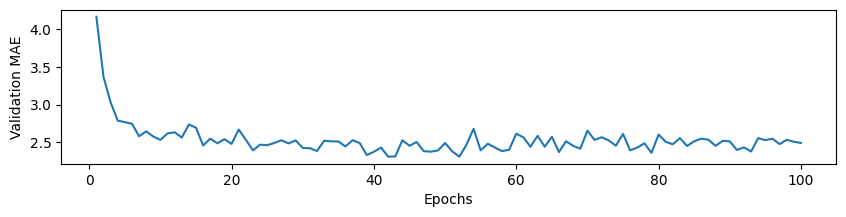

In [48]:
average_mae_history = np.array(all_mae_histories).mean(axis=0)
plt.figure(figsize=(10,2))
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
def smooth_curve(points, beta = 0.9):
    smoothed_points = []
    for current in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(beta * previous + (1 - beta) * current)
        else:
            smoothed_points.append(current)
    return smoothed_points

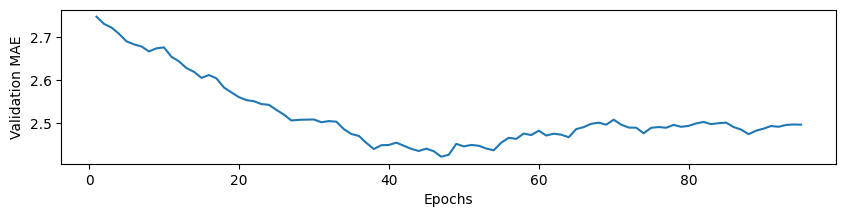

In [15]:
smooth_mae_history = smooth_curve(average_mae_history[5:])
plt.figure(figsize=(10,2))
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Experiments

- Run k-fold validation on the Boston dataset;
- At first, we used a mini-batch of 1. Experiment with different mini-batch sizes. What do you observe? Can you account for your observation?
- Run a series of experiments to find the best model, like in previous labs.
- A more advanced experiment would be to implement *iterated K-fold validation with shuffling*, as mentioned in the lecture.

#### Experiment 1

- Test various batch sizes

First of all, here are two examples of functions plotting the validation MAE and the smoothed version.

The following uses two subplots, aligning the `x` axis.

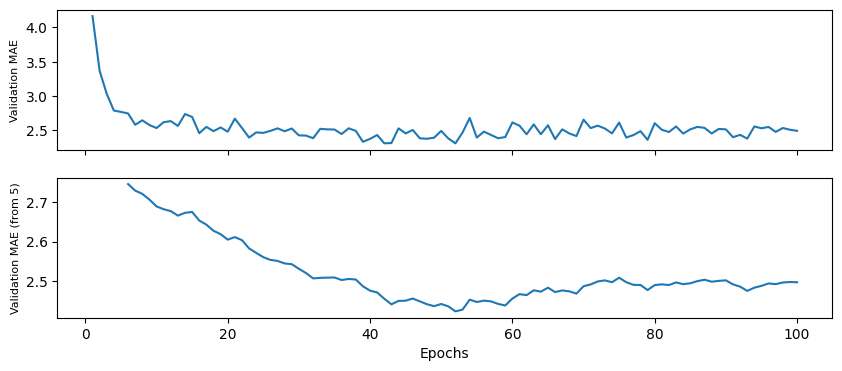

In [51]:
def subplots_avg_and_smooth(average_mae_history, omit=5):
    
    fig, axs = plt.subplots(2,1, figsize=(10,4), sharex=True)

    # plot the raw history
    axs[0].plot(range(1, len(average_mae_history) + 1), average_mae_history)
    axs[0].set_ylabel('Validation MAE', fontsize=8)

    # create the EMA data and plot it
    smooth_mae_history = smooth_curve(average_mae_history[omit:])
    axs[1].plot(range(omit + 1, len(smooth_mae_history) + omit + 1), smooth_mae_history)
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel(f"Validation MAE (from {omit})", fontsize=8)

    plt.show()

subplots_avg_and_smooth(average_mae_history)

The second one plots the exponential moving average (EMA) of our MAE values on top of the raw ones.

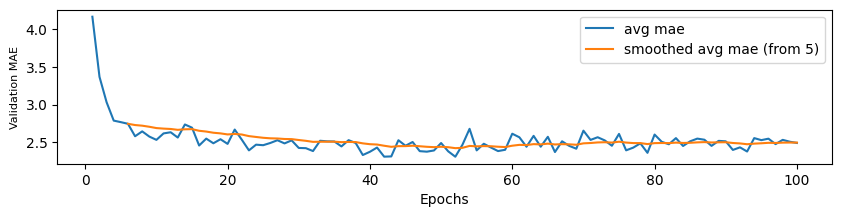

In [52]:
def plot_avg_and_smooth(average_mae_history, omit=5):

    smooth_mae_history = smooth_curve(average_mae_history[omit:])
    
    plt.figure(figsize=(10,2))
    plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, label="avg mae")
    plt.plot(range(omit + 1, len(smooth_mae_history) + omit + 1), smooth_mae_history, label=f"smoothed avg mae (from {omit})")
    plt.ylabel('Validation MAE', fontsize=8)
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

plot_avg_and_smooth(average_mae_history)

I will now gather the code required for the K-Fold algorithm into a function, for ease of use.

A slightly modified callback that knows which fold we are in.

In [24]:
class FoldCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, fold):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.epochs = epochs
        self.fold = fold
    def on_epoch_begin(self, epoch, logs=None):
        c = ['|', '/', '-', '\\']
        print(f"\r        {c[epoch % 4]} fold: {self.fold + 1} | epoch: {epoch+1}/{self.epochs}", end="")
    def on_train_end(self, logs=None):
        print()

The K-fold validation function.

In [25]:
def run_kfold(
    train_data, train_targets, model_params,
    batch_size, K=4, num_epochs=100,
    clear=True
):
    """
    Run the K-Fold algorithm
    
    Args:
        train_data (np.array or tf tensor): the training data
        train_targets (np.array or tf tensor): the training targets
        model_params (dict): a dictionary containing parameters (used to configure the model in
             various runs, and to retrieve the best params later), structured like so:
            {
                "layers":           [units_1, units_2, ..., units_3], # units per layer, determines the number of layers
                "activation":       "relu", # which activation to use at each layer
                "dropout_rate":     0,      # the dropout rate (0: no dropout)
                "regularizer_rate": 0,      # the regularizer rate (not used if "regularizer" is None)
                "regularizer":      None    # the regularizer to use (pass a regularizer object, e.g. `tf.keras.regularizers.l2`)
            }
        batch_size (int): the batch size
        K (int): the number of folds
        num_epochs (int): the number of epochs per training run
        clear (bool): whether to call tf.keras.backend.clear_session() before the runs

    Returns:
        all_mae_histories (list, validation mae values for K runs)
    """    
    if clear:
        tf.keras.backend.clear_session()
        
    num_val_samples = len(train_data) // K
    all_mae_histories = []
    
    for i in range(K):
        
        # Prepare the validation data: data from partition i
        a, b = i * num_val_samples, (i + 1) * num_val_samples
        val_data = train_data[a : b]
        val_targets = train_targets[a : b]
        
        # Prepare the training data: data from all other partitions
        partial_train_data = np.concatenate([train_data[:a], train_data[b:]], axis=0)
        partial_train_targets = np.concatenate([train_targets[:a], train_targets[b:]], axis=0)
    
        # Build the Keras model (already compiled)
        model = build_model(**model_params) # https://realpython.com/python-kwargs-and-args/
        
        # Train the model
        history = train(
            model,
            partial_train_data,
            partial_train_targets,
            validation_data=(val_data, val_targets),
            num_epochs=num_epochs, batch_size=batch_size,
            callbacks=[FoldCallback(num_epochs, i)]
        )
    
        mae_history = history.history['val_mae']
        all_mae_histories.append(mae_history)
        del model # save memory
        
    return all_mae_histories

I will use the same model parameters as in the initial example. I also implement a helper function to print the parameters easily.

In [30]:
model_params = {
    "layers":           [64, 64],  
    "activation":       "relu",
    "dropout_rate":     0,
    "regularizer_rate": 0,
    "regularizer":      None
}

# https://realpython.com/python-kwargs-and-args/
def print_params(params, **kwargs):
    print(f"Model params:")
    # print params
    for k,v in params.items():
        print(f" - {k}: {v}")
    # print additional keyword arguments
    for k,v in kwargs.items():
        print(f" - {k}: {v}")
    print("-" * 30) 

print_params(model_params)

Model params:
 - layers: [64, 64]
 - activation: relu
 - dropout_rate: 0
 - regularizer_rate: 0
 - regularizer: None
------------------------------


Training four models with four different batch sizes.

Additionally, it is useful to have a helper function to retrieve the epoch and lowest value from a list of value.

In [33]:
def retrieve_lowest_mae(hist):
    epoch = np.argmin(hist)
    best_mae = hist[epoch]
    return epoch, best_mae

We are now ready to train models on various batch sizes.

Testing various batch sizes
---------------------------
Model params:
 - layers: [64, 64]
 - activation: relu
 - dropout_rate: 0
 - regularizer_rate: 0
 - regularizer: None
------------------------------
 - batch size: 1

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


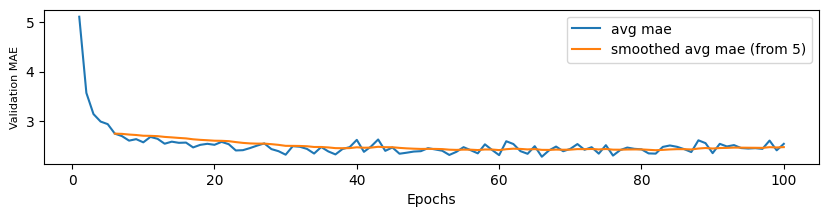

      Lowest MAE: 2.2867687344551086 at epoch 66
      --------------------------------------------------------------------------------

 - batch size: 16

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


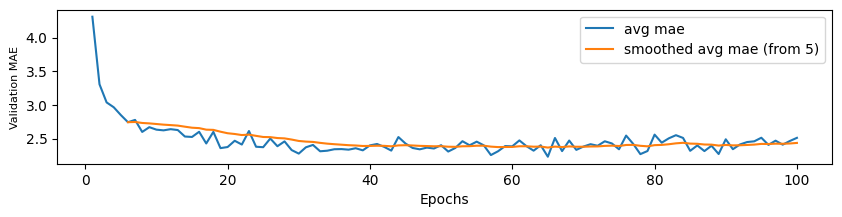

      Lowest MAE: 2.231154680252075 at epoch 65
      --------------------------------------------------------------------------------

 - batch size: 64

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


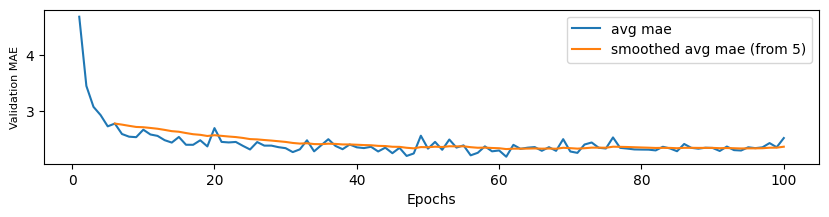

      Lowest MAE: 2.1942073702812195 at epoch 61
      --------------------------------------------------------------------------------

 - batch size: 256

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


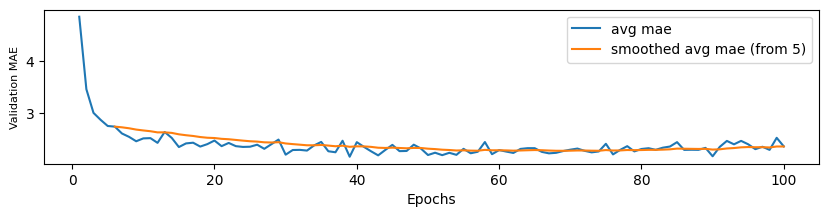

      Lowest MAE: 2.1745035648345947 at epoch 39
      --------------------------------------------------------------------------------

 - batch size: 512

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100
        \ fold: 4 | epoch: 100/100


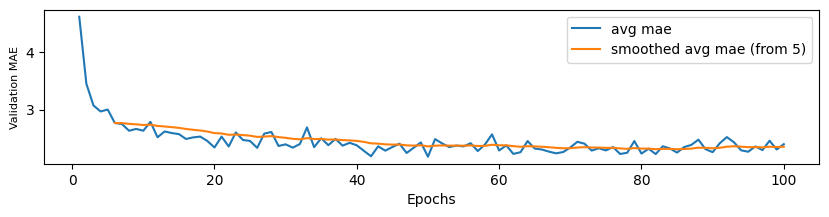

      Lowest MAE: 2.17601478099823 at epoch 50
      --------------------------------------------------------------------------------

Results:
 - batch size:   1 | lowest val mae: 2.28677 at epoch: 65
 - batch size:  16 | lowest val mae: 2.23115 at epoch: 64
 - batch size:  64 | lowest val mae: 2.19421 at epoch: 60
 - batch size: 512 | lowest val mae: 2.17601 at epoch: 49
 - batch size: 256 | lowest val mae: 2.17450 at epoch: 38

The best MAE result, 2.1745035648345947 (epoch 38), was achieved with batch size 256.


In [53]:
import gc # we will need to clear the memory to prevent the Colab session to crash

num_epochs = 100
batch_sizes = [1, 16, 64, 256, 512]

msg = "Testing various batch sizes"
print(msg)
print("-"*len(msg))
print_params(model_params)

all_epochs = []
all_maes = []
for b in batch_sizes:

    print(f" - batch size: {b}")
    print()

    # run k-fold
    mae_histories = run_kfold(
        train_data, train_targets, model_params,
        batch_size=1, K=4, num_epochs=num_epochs
    )
    
    # compute the mean
    avg_mae_history = np.array(mae_histories).mean(axis=0)
    
    # plot
    plot_avg_and_smooth(avg_mae_history)
    
    # retrieve & save results
    best_mae_epoch, best_mae = retrieve_lowest_mae(avg_mae_history)
    all_epochs.append(best_mae_epoch)
    all_maes.append(best_mae)

    # print best mae
    print(f"      Lowest MAE: {best_mae} at epoch {best_mae_epoch+1}")
    print("      " + "-" * 80)
    print()

    gc.collect() # save memory

# sort all our results
indz = np.argsort(np.array(all_maes))
sorted_epochs = np.array(all_epochs)[indz][::-1] # reverse sort
sorted_maes = np.array(all_maes)[indz][::-1]
sorted_batch_sizes = np.array(batch_sizes)[indz][::-1]

# string formatting
longest_bs = len(str(max(batch_sizes)))
longest_ep = len(str(max(all_epochs)))

# print our final results
print("=" * 80)
print("Results:")
for bs, mae, ep in zip(sorted_batch_sizes, sorted_maes, sorted_epochs):
    print(f" - batch size: {bs:>{longest_bs}} | lowest val mae: {mae:>.5f} at epoch: {ep:>{longest_ep}}")

print()
print(f"The best MAE result, {sorted_maes[-1]} (epoch {sorted_epochs[-1]}), was achieved with batch size {sorted_batch_sizes[-1]}.")

The best value is obtained with batch size `256`, and it so happens that it is also the run that reached the best result the fastest, at epoch `38`. In the runs performed, increasing the batch size seems to have had a positive effect on our final results, at least up until `256`, after which the MAE value stagnaged (it is technically worse at `512`, but by a very small margin). It might be interesting to see if this result is robust, by running experiments with more batch sizes, and seeing if we see a smooth decrease of returns as the batch size increases. This would also help establishing what part the randomness in our system plays in this particular result (best result reached with batch size `256`, at epoch `38`): if the MAE value truly stagnates beyond a certain batch size for these hyperparameters, then random runs might yield a best result for various batch sizes beyond this point, without any significant influence on our results. In this case, it might be best to focus on what might be the smallest batch size from which we can reasonably establish the stagnation starts from.

It is also interesting to note that the epoch at which the best (lowest) MAE value is reached is very similar (around 60-66) for batch sizes `1`, `16`, `64`. Given that the epochs seem to behave in a relatively similar fashion as with the MAE values themselves (with the lowest for batch size `256`, then going back up), more experiments with more batch sizes could also help us ascertain whether there is a phenomenon where there is a 'sweet spot', yielding both the best validation MAE value, and at the earliest epoch, with worsening results when we increase the batch size beyond this point.

If we plotted those results, we would then expect to see the val MAE curve decreasing and flatlining (or increasing again perhaps) after the sweet spot, whereas the best epoch would display a U shape, with the numbers increasing again with higher batch sizes.

#### Experiments 2

- Testing random search with *iterated K-fold validation with shuffling*

Using the tools we developed above, we can now proceed to expand our experiments to tune other hyperparameters as well. Even if this isn't as common as grid search, **random search**, where we randomly select has some hyperparameters, and set up the number of runs we wish to perform according to our compute and time constraints, has some proponents, such as Andrej Karpathy. He summarizes the argument in favour of random search in the following way: "Intuitively, this is because neural nets are often much more sensitive to some parameters than others. In the limit, if a parameter a matters but changing b has no effect then you’d rather sample a more throughly than at a few fixed points multiple times."  
Source: ["A Recipe for Training Neural Networks", 5. Tune, Apr 25, 2019](https://karpathy.github.io/2019/04/25/recipe/#5-tune)

Here is an additional plotting helper, this time to plot multiple MAE histories (with some transparency) as well as the average of those.

In [63]:
def plot_multiple_histories(histories, avg, label="fold:", omit=5, figsize=(8,2)):
    plt.figure(figsize=figsize)
    # quite subtle and frustrating business to make sure the epochs on the 
    # plots show the same results as when printing (shifts by ones are the worst!)
    for i, hist in enumerate(histories):
        h = hist[omit:]
        plt.plot(range(omit + 1, len(h) + omit + 1), h, label=f"{label} {i+1}", alpha=.2)
    a = avg[omit:]
    plt.plot(range(omit + 1, len(a) + omit + 1), a, label=f"average", color='r')
    plt.xticks(range(omit + 1, len(a) + omit + 1), fontsize=6)
    plt.ylabel('Validation MAE', fontsize=8)
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

We will need a utility to generate random hyperparameters. Here, each hyperparameter we wish to test is examined in advance, so that we have an idea of what values to expect, and then we use `NumPy` either to generate numbers, or to pick one element in an array for us.

In [55]:
def random_params():
    return {
        "layers":           [2**np.random.randint(3,8)] * np.random.randint(1,4), # [8] to [256,256,256]       
        "activation":       np.random.choice(["relu", "tanh"]),
        "dropout_rate":     np.random.choice([0, .1, .3, .5]),  # this way 0 dropout sometimes happens
        "regularizer_rate": np.random.random() * .5,            # 0 - .5
        "regularizer":      np.random.choice(
                                [None, tf.keras.regularizers.l1, tf.keras.regularizers.l2]
                            ),
    }

print_params(random_params()) # generate and print

Model params:
 - layers: [32, 32]
 - activation: relu
 - dropout_rate: 0.3
 - regularizer_rate: 0.07245814473346912
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
------------------------------


Now it is possible to write a function wrapping `run_kfold`, and feeding it a shuffled version of the dataset.

In [92]:
def iterated_kfold(
    train_data, train_targets,
    model_params, batch_size,
    n_iter=5, K=4, num_epochs=100,
):

    """
    Run Iterated K-Fold with Shuffling
    
    Args:
        train_data (np.array or tf tensor): the training data
        train_targets (np.array or tf tensor): the training targets
        model_params (dict): a dictionary containing parameters (used to configure the model in
             various runs, and to retrieve the best params later), structured like so:
            {
                "layers":           [units_1, units_2, ..., units_3], # units per layer, determines the number of layers
                "activation":       "relu", # which activation to use at each layer
                "dropout_rate":     0,      # the dropout rate (0: no dropout)
                "regularizer_rate": 0,      # the regularizer rate (not used if "regularizer" is None)
                "regularizer":      None    # the regularizer to use (pass a regularizer object, e.g. `tf.keras.regularizers.l2`)
            }
        batch_size (int): the batch size
        K (int): the number of folds for the K-fold algorithm
        n_iter (int): the number of iterations (how many shufflings & k-folds we perofrm)
        num_epochs (int): the number of epochs per training run

    Returns:
        best_overall_mae (float, best MAE value for all runs)
        best_overall_mae_epoch (int, epoch at which the best value was reached)
        iterated_avg_mae_history (list, average validation mae values for the best K-fold run)
    """   
    
    assert train_data.shape[0] == train_targets.shape[0], f"`train_data` ({train_data.shape[0]}) and `train_targets` ({train_targets.shape[0]}) must contain the same amount of elements!"

    all_iterated_mae_histories = []
    
    for i in range(n_iter):
        
        print()
        print(f"Iteration: {i+1}/{n_iter} | K-folding with k={K}")
        print()

        # shuffling indices
        shuffled_indz = np.random.permutation(train_data.shape[0])

        # using indices to shuffle data & targets
        shuffled_train_data = train_data[shuffled_indz]
        shuffled_train_targets = train_targets[shuffled_indz]

        # run k-fold on shuffled dataset
        mae_histories = run_kfold(
            shuffled_train_data, shuffled_train_targets,
            model_params, batch_size,
            K=K, num_epochs=num_epochs,
        )
        
        # compute the mean and append to our histories
        avg_mae_history = np.array(mae_histories).mean(axis=0)
        all_iterated_mae_histories.append(avg_mae_history)
        
        # # plot each fold & average
        # plot_multiple_histories(mae_histories, avg_mae_history)
        
        best_mae_epoch, best_mae = retrieve_lowest_mae(avg_mae_history)
        print()
        print(f"      Lowest average MAE: {best_mae} at epoch {best_mae_epoch + 1}.")
        print("      " + "-" * 80)
        
        gc.collect() # save memory

    print()
    msg = f"Finished performing {n_iter} iterations, results:"
    print("=" * len(msg))
    print(msg)    

    iterated_avg_mae_history = np.array(all_iterated_mae_histories).mean(axis=0)

    # plot
    plot_multiple_histories(
        all_iterated_mae_histories, iterated_avg_mae_history, 
        label="iteration:", figsize=(17,3))

    best_overall_mae_epoch, best_overall_mae = retrieve_lowest_mae(iterated_avg_mae_history)
    
    print()
    print(f"After {n_iter} x {K} = {n_iter*K} runs, lowest MAE result: {best_overall_mae} at epoch {best_overall_mae_epoch + 1}.")
    print()
    print_params(model_params)
    
    return best_overall_mae, best_overall_mae_epoch, iterated_avg_mae_history

Here, we generate random parameters outside the call to `iterated_kfold`, and simply save the current parameters if the MAE result is lower than the currently saved best result. This cell is likely to take some time to run, especially if `n_trials` is large!

Here we run `5` trials (sets of hyperparameters), and each of those is tested on `2` iterations of the K-fold algorithm (with `K = 3`), each run training for `100` epochs, as a demonstration of how the system works, but given more time, one could certainly consider increasing these numbers, to see if it is possible to obtain an even lower MAE value.

Random Search through Iterated K-Fold with Shuffling
----------------------------------------------------

Trial: 1/5, generating random hyperparameters...

Model params:
 - layers: [64, 64]
 - activation: tanh
 - dropout_rate: 0.5
 - regularizer_rate: 0.32538042934518574
 - regularizer: None
 - batch_size: 4
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 2.9820338090260825 at epoch 97.
      --------------------------------------------------------------------------------

Iteration: 2/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 3.0378219286600747 at epoch 79.
      --------------------------------------------------------------------------------

Finished performing 2 iterations, results:


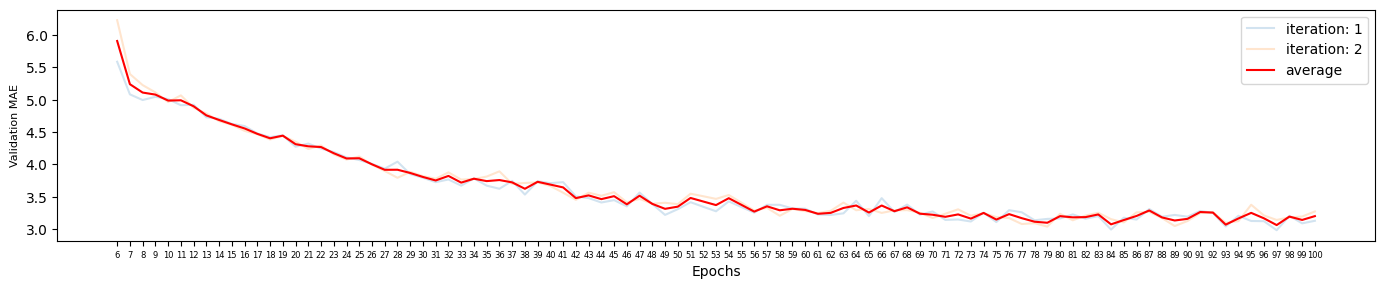


After 2 x 3 = 6 runs, lowest MAE result: 3.0615156491597495 at epoch 97.

Model params:
 - layers: [64, 64]
 - activation: tanh
 - dropout_rate: 0.5
 - regularizer_rate: 0.32538042934518574
 - regularizer: None
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 2/5, generating random hyperparameters...

Model params:
 - layers: [8, 8]
 - activation: relu
 - dropout_rate: 0.0
 - regularizer_rate: 0.4623829762216169
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
 - batch_size: 8
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 2.4855740070343018 at epoch 98.
      --------------------------------------------------------------------------------

Iteration: 2/2 | K-folding with k=3

        \ f

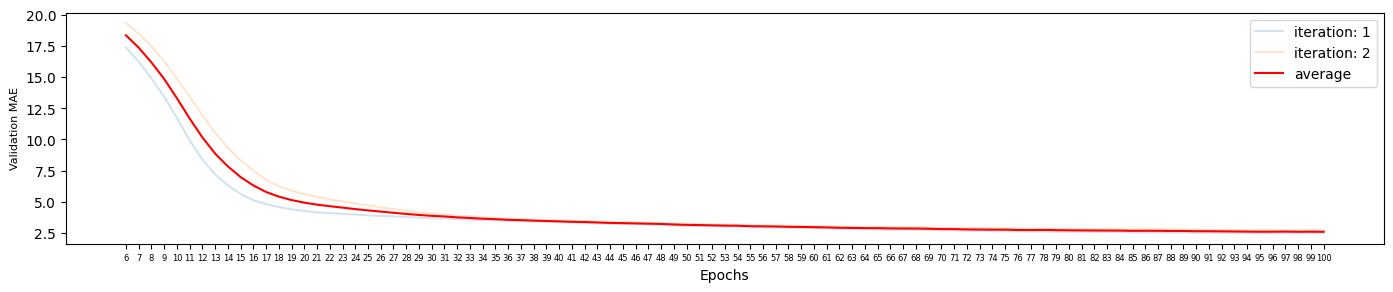


After 2 x 3 = 6 runs, lowest MAE result: 2.6019484599431353 at epoch 100.

Model params:
 - layers: [8, 8]
 - activation: relu
 - dropout_rate: 0.0
 - regularizer_rate: 0.4623829762216169
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 3/5, generating random hyperparameters...

Model params:
 - layers: [32, 32]
 - activation: relu
 - dropout_rate: 0.5
 - regularizer_rate: 0.03766206674594769
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
 - batch_size: 8
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 2.5754016240437827 at epoch 94.
      --------------------------------------------------------------------------------

Ite

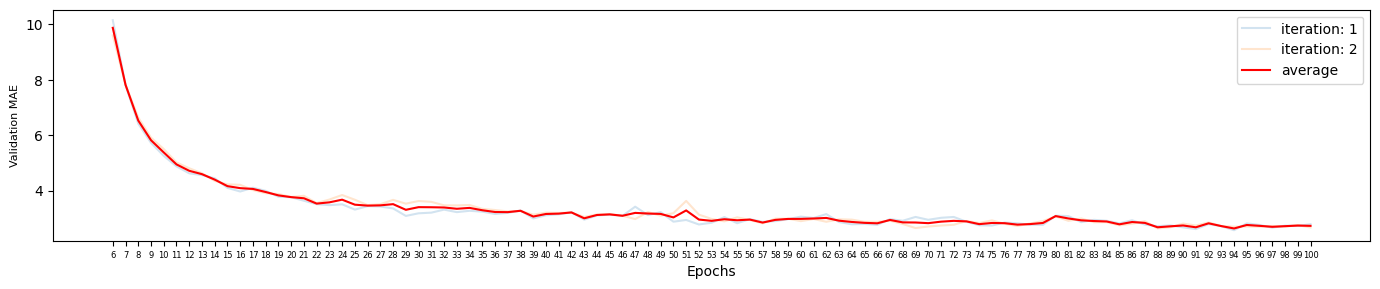


After 2 x 3 = 6 runs, lowest MAE result: 2.639119863510132 at epoch 94.

Model params:
 - layers: [32, 32]
 - activation: relu
 - dropout_rate: 0.5
 - regularizer_rate: 0.03766206674594769
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 4/5, generating random hyperparameters...

Model params:
 - layers: [64, 64, 64]
 - activation: tanh
 - dropout_rate: 0.3
 - regularizer_rate: 0.23652515648805433
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
 - batch_size: 8
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 2.797534147898356 at epoch 94.
      --------------------------------------------------------------------------------


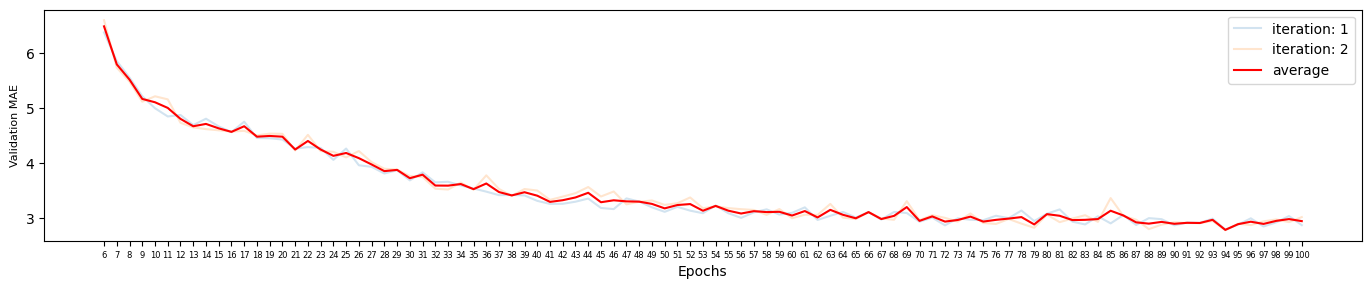


After 2 x 3 = 6 runs, lowest MAE result: 2.7910899718602495 at epoch 94.

Model params:
 - layers: [64, 64, 64]
 - activation: tanh
 - dropout_rate: 0.3
 - regularizer_rate: 0.23652515648805433
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------

Trial: 5/5, generating random hyperparameters...

Model params:
 - layers: [16, 16]
 - activation: tanh
 - dropout_rate: 0.3
 - regularizer_rate: 0.18472398881196012
 - regularizer: <class 'keras.src.regularizers.regularizers.L1'>
 - batch_size: 1
------------------------------

Iteration: 1/2 | K-folding with k=3

        \ fold: 1 | epoch: 100/100
        \ fold: 2 | epoch: 100/100
        \ fold: 3 | epoch: 100/100

      Lowest average MAE: 3.56259822845459 at epoch 85.
      --------------------------------------------------------------------------------


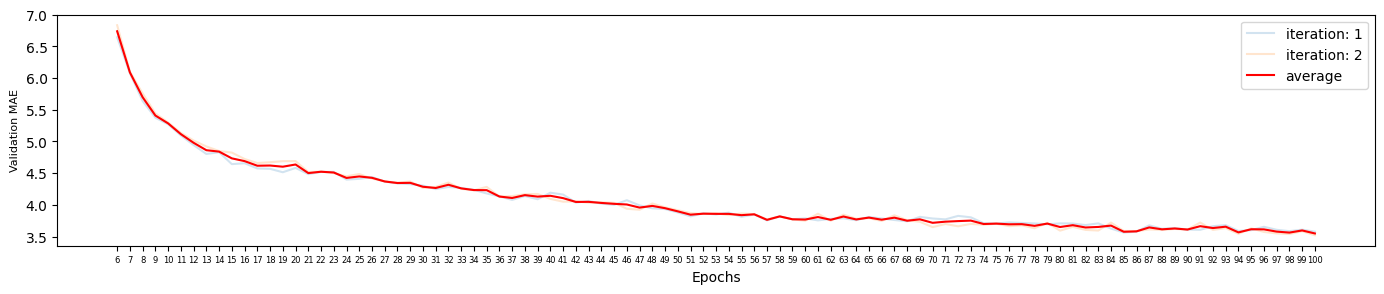


After 2 x 3 = 6 runs, lowest MAE result: 3.5483266909917193 at epoch 100.

Model params:
 - layers: [16, 16]
 - activation: tanh
 - dropout_rate: 0.3
 - regularizer_rate: 0.18472398881196012
 - regularizer: <class 'keras.src.regularizers.regularizers.L1'>
------------------------------

--------------------------------------------------------------------------------------------------------------------------------------------
Best result found: MAE: 2.6019484599431353 at epoch 100.
Model params:
 - layers: [8, 8]
 - activation: relu
 - dropout_rate: 0.0
 - regularizer_rate: 0.4623829762216169
 - regularizer: <class 'keras.src.regularizers.regularizers.L2'>
 - batch_size: 8
------------------------------


In [94]:
best_results = {
    "mae": np.inf, # to start with
}

msg = "Random Search through Iterated K-Fold with Shuffling"
print(msg)
print("-"*len(msg))

n_trials = 5

# O nestedness! We try 10 different random parameters
for i in range(n_trials):

    # get random params
    model_params = random_params()
    # get random batch size
    batch_size = 2 ** np.random.randint(0,5)

    # print
    print()
    print(f"Trial: {i+1}/{n_trials}, generating random hyperparameters...")
    print()
    print_params(model_params, batch_size=batch_size)

    # run n_iter x k experiments
    best_mae, best_epoch, _ = iterated_kfold(
        train_data, train_targets,
        model_params, batch_size,
        num_epochs=100,
        n_iter=2, K=3,
    )
    
    # update results
    if best_mae < best_results["mae"]:
        best_results = {
            "mae": best_mae,
            "epoch": best_epoch,
            "params": model_params,
            "batch_size": batch_size
        }

    print()
    print("-" * 140)

print(f"Best result found: MAE: {best_results['mae']} at epoch {best_results['epoch'] + 1}.")
print_params(best_results["params"], batch_size=best_results["batch_size"])

## 2. Conclusion

It is now possible for us to retrain a final model (with the hyperparameters that yielded the best performance, up to the best epoch) on the entire the training data (`train_data` and `train_targets`) and evaluate on the test data (`test_data`, `test_targets`).

In [95]:
best_results

{'mae': 2.6019484599431353,
 'epoch': 99,
 'params': {'layers': [8, 8],
  'activation': 'relu',
  'dropout_rate': 0.0,
  'regularizer_rate': 0.4623829762216169,
  'regularizer': keras.src.regularizers.regularizers.L2},
 'batch_size': 8}

In [98]:
final_model = build_model(**best_results["params"])
_ = train(
    final_model,
    train_data,
    train_targets,
    validation_data=None,
    num_epochs=best_results["epoch"],
    batch_size=best_results["batch_size"]
)

result = model.evaluate(test_data, test_targets, verbose=0)
print("Final results:")
print(f"MSE: {result[0]}, MAE: {result[1]}")

Final results:
MSE: 28.463010787963867, MAE: 3.32786226272583


Our final result is an MAE of $3.32$ (approximately \$3'320) on the test set. This is not an amazing result: one would hope that running more trials would lead better hyperparameters. It would in fact be quite damning if, after running many trials of the **random search**, we weren't able to improve this result by much. Then, one would probably have to study the influence of each parameter more closely, to see which ones are more likely to yield a better performance (one thing that was not included in the current framework was a thorough study of optimizers and learning rates, for instance!).

We can now use your model to make predictions on by selecting one data point in `test_data`, and compare the prediction to the equivalent price in `test_targets`.

In [100]:
n = np.random.randint(test_data.shape[0])
price = final_model.predict(test_data[n:n+1], verbose=0)[0,0]
print(f"Test sample {n}:")
print(f"   prediction: {int(price * 1000):,}$")
print(f" ground truth: {int(test_targets[n] * 1000):,}$.")

Test sample 65:
   prediction: 21,740$
 ground truth: 21,900$.


## 3. Advanced/Optional: the California dataset

In the [`lab-5-CALIFORNIA.ipynb`](https://github.com/jchwenger/AI/blob/main/labs/5-lab/lab-5-CALIFORNIA.ipynb), steps are given to process the data in the California housing dataset from scratch. This is more involved, as the dataset has to be downloaded and processed manually. This counts as a 'not covered' dataset in the first coursework.

### Save and load models

To save and load models locally, you can use [the high-level API](https://www.tensorflow.org/tutorials/keras/save_and_load):
```python
model.save("my_imdb_model.keras")
```
Later one, to reload it, use:
```python
reloaded_model = tf.keras.models.load_model('my_imdb_model.keras')
```

It is also possible to save not just the model, but also the state of your optimiser, and every variable used during training, using the more involved [checkpoints](https://www.tensorflow.org/guide/checkpoint#create_the_checkpoint_objects).